In [8]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = "cpu"
torch.set_grad_enabled(False)
torch.set_default_device(device)

d = torch.tensor(np.load("ks2d_short.npy"))
maxval, minval = d.max(), d.min()
normalize = lambda x: (x-minval)/(maxval-minval)
denormalize = lambda x: x*(maxval-minval)+minval
d = normalize(d)

def pad(d, axis, extent, mode="circular", val_left=None, val_right=None):
    permutation = list(range(len(d.shape)))
    permutation[axis] = len(d.shape)-1
    permutation[-1] = axis
    d = d.permute(*permutation)

    if mode == "circular":
        assert extent <= d.shape[-1]
        left, right = d[...,-extent:], d[...,:extent]
    elif mode == "dirichlet": 
        shape = list(d.shape[:-1]) + [extent]
        left, right = torch.ones(shape)*val_left, torch.ones(shape)*val_right
    else:
        raise Exception

    d = torch.cat((left, d, right), dim=-1)
    d = d.permute(*permutation)
    return d

def conv1d(d, axis, kernel):
    # assumes d takes the form 
    # batch x channels x a1 x a2 ... x an
    
    # moves axis and channel to the right
    perm1 = list(range(len(d.shape)))
    perm1[axis] = len(d.shape)-1
    perm1[-1] = axis
    d = d.permute(*perm1)
    perm2 = list(range(len(d.shape)))
    perm2[ 1]  = len(d.shape)-2
    perm2[-2] = 1
    d = d.permute(*perm2)

    # conflates the first few axes
    shape = d.shape
    d = d.view(-1, *shape[-2:])
    # applies kernel and inverts the permutation
    d = kernel(d)
    d = d.view(*shape[:-2], *d.shape[-2:])
    d = d.permute(*perm2)
    d = d.permute(*perm1)
    return d


class ConvELM2D(torch.nn.Module):
    def __init__(self, extent=2, hidden=100, mode="sliced", bc=[{"mode":"circular"}, {"mode":"circular"}]):
        super().__init__()
        self.extent = extent
        self.ks = 2*self.extent + 1
        self.hidden = hidden
        self.bc = bc
        self.mode = mode
        assert self.mode in ["sliced", "full"]

        if self.mode == "sliced":
            self.conv1 = torch.nn.Conv1d(1, self.hidden, self.ks, bias=False).double()
            self.conv2 = torch.nn.Conv1d(self.hidden, self.hidden, self.ks, groups=self.hidden, bias=False).double()
        elif self.mode == "full":
            self.conv = torch.nn.Conv2d(1, self.hidden, self.ks, bias=False).double()

        self.nl =  torch.nn.Softplus().double()
        self.out_layer = torch.nn.Conv2d(self.hidden, 1, 1, bias=False).double()

    def phi(self, X):
        assert len(X.shape) == 4, f"input must have the form (batch, channels, im1, im2), but has shape {X.shape}"
        X = pad(X, 2, self.extent, **self.bc[0])
        X = pad(X, 3, self.extent, **self.bc[1])

        if self.mode == "sliced":
            X = conv1d(X, 2, self.conv1)
            X = conv1d(X, 3, self.conv2)
        elif self.mode == "full":
            X = self.conv(X)

        X = self.nl(X)
        return X
    
    def forward(self, X):
        assert len(X.shape) in [3,4], f"input must have the form (batch, channels, im1, im2) OR (channels, im1, im2), but has shape {X.shape}"
        unbatched = len(X.shape)==3
        if unbatched: X = X.unsqueeze(0)
        phiX = self.phi(X)
        out = self.out_layer(phiX)
        if unbatched: out = out.squeeze(0)
        return out

    def train(self, X, Y):
        phiX = self.phi(X)
        phiX = phiX.permute(0,2,3,1) # shifts the channel axis to the last index
        phiX = phiX.reshape(-1, self.hidden) # conflates the first few axes, except for the channels
        Y = Y.view(-1, 1)
        A = torch.linalg.lstsq(phiX, Y).solution.transpose(0,1)
        A = A.view(1, self.hidden, 1, 1)
        self.out_layer.weight.data = A


# boundary conditions used in training data
BC_0 = { "mode": "circular", "val_left": None, "val_right": None }
BC_1 = { "mode": "circular", "val_left": None, "val_right": None }

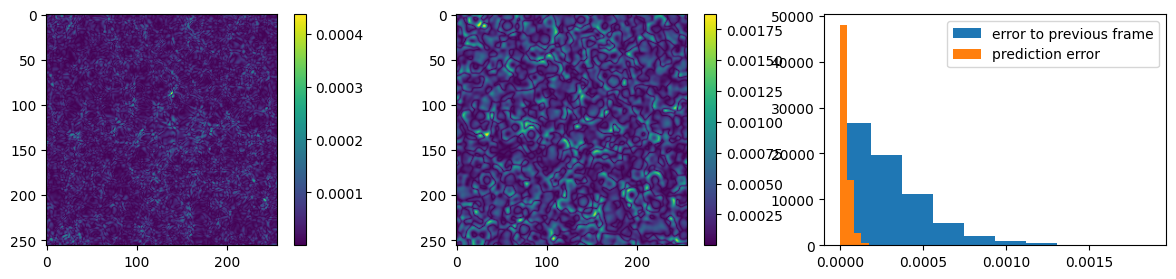

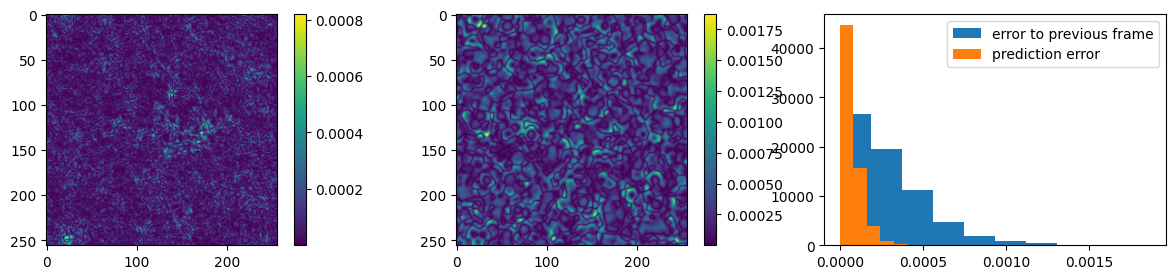

In [9]:
# compares steerable with non-steerable kernels
def make_steerable_kernels(n, ks):
    coordinates = torch.linspace(-1,1,ks)
    coordinates = torch.meshgrid((coordinates,coordinates), indexing="xy")
    coordinates = torch.stack(coordinates, dim=0)
    radius = coordinates.pow(2).sum(dim=0).sqrt()
    theta = torch.atan2(coordinates[1,...],coordinates[0,...])
    unique_radii = radius.unique() 
    unique_thetas = theta.unique()

    theta_values = 2*torch.rand((n, *unique_thetas.shape))-1
    radius_values = 2*torch.rand((n, *unique_radii.shape))-1
    kernels_theta = torch.zeros((n,ks,ks))
    kernels_rad = torch.zeros((n,ks,ks))

    for idx, t in enumerate(unique_thetas): kernels_theta[:,theta == t] = theta_values[:,None,idx]
    for idx, r in enumerate(unique_radii): kernels_rad[:,radius == r] = radius_values[:,None,idx]
    kernels = kernels_theta * kernels_rad
    return kernels

extent = 2
ks = 2*extent + 1
n_kernels = 100
models = [
    ConvELM2D(extent, n_kernels, mode="full", bc=[BC_0,BC_1]),
    ConvELM2D(extent, n_kernels, mode="full", bc=[BC_0,BC_1])
]
models[0].conv.weight.data = make_steerable_kernels(n_kernels, ks).unsqueeze(1).double()
models[1].conv.weight.data = 2*torch.rand((100, 1, 5, 5)).double() - 1

X = d[0,None,None,...] 
# X = X + torch.distributions.Normal(0, 1e-4).sample(X.shape) 
Y = d[1,None,None,...]

for model in models: model.train(X, Y)

# prediction
for model in models:
    fig, ax = plt.subplots(1,3,figsize=(15,3))
    err = ( model(d[0,None,...])-d[1,None,...] ).abs().squeeze(0)
    err_prev = ( d[0,...]-d[1,...] ).abs()
    plt.colorbar(ax[0].imshow(err.cpu().numpy()))
    plt.colorbar(ax[1].imshow(err_prev.cpu().numpy()))
    ax[2].hist(err_prev.cpu().flatten(), label="error to previous frame")
    ax[2].hist(err.cpu().flatten(), label="prediction error")
    ax[2].legend()
    plt.show()

In [10]:
model = models[0]

# enjoy a nice animation
import itertools
%matplotlib qt
torch.set_grad_enabled(False)

# Dirichlet boundary conditions
BC_0 = { "mode": "dirichlet", "val_left": 0, "val_right": 0 } # vertical axis
BC_1 = { "mode": "dirichlet", "val_left": 0, "val_right": 0 } # horizontal axis
model.bc = [BC_0, BC_1]

# fit initial condition to the boundary conditions, i.e., smoothly transition
# boundary values to 0
T = d[0,None,...]
z = torch.sin(torch.linspace(0,torch.pi,d.shape[1])).expand_as(T)
z = z * torch.sin(torch.linspace(0,torch.pi,d.shape[1])).expand_as(T).transpose(1,2)
T = T * z

im = plt.matshow(T[0,...].cpu().numpy(), vmin=0, vmax=1)
model_fast= model.to(torch.float32).to(device)
T_fast = T.to(torch.float32).to(device)
# energy = T_fast.mean()
for j in itertools.count():
    T_fast = model_fast(T_fast)
    # T_fast = energy + T_fast - T_fast.mean()
    if j % 20 == 0:
        im.set_data(T_fast[0,...].cpu())
        plt.pause(0.000001)
        plt.draw()

KeyboardInterrupt: 